In [1]:
import copy

import h5py
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astroNN.gaia import fakemag_to_logsol
from astroNN.shared.matplotlib import pylab_style
from astropy.stats import mad_std
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from stellarperceptron.model import StellarPerceptron

pylab_style(paper=True)

device = "cuda:0"


def top_cbar(ax, mappable, text=None, labelpad=None, ticksformat=None):
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("top", size="7%", pad="2%")
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal", format=ticksformat)
    cbar.set_label(text, labelpad=labelpad)
    cax.xaxis.set_ticks_position("top")
    cax.xaxis.set_label_position("top")
    return cbar


xp_apogee_testing = h5py.File("./data_files/testing_set.h5", mode="r")

good_idx = (
    np.ones(len(xp_apogee_testing["raw"]["teff"][()]), dtype=bool)  # all are good
)

val_labels = np.column_stack(
    [
        xp_apogee_testing["raw"]["xp_coeffs_gnorm"][()],
        xp_apogee_testing["raw"]["bprp"][()],
        xp_apogee_testing["raw"]["jh"][()],
        xp_apogee_testing["raw"]["jk"][()],
        xp_apogee_testing["raw"]["teff"][()],
        xp_apogee_testing["raw"]["logg"][()],
        xp_apogee_testing["raw"]["m_h"][()],
        xp_apogee_testing["raw"]["logc19"][()],
        xp_apogee_testing["raw"]["g_fakemag"][()],
    ]
)[good_idx]

obs_names = np.stack(
    [
        *[f"bp{i}" for i in range(55)],
        *[f"rp{i}" for i in range(55)],
        "bprp",
        "jh",
        "jk",
        "teff",
        "logg",
        "m_h",
        "logebv",
        "g_fakemag",
    ]
)

val_labels_df = pd.DataFrame(val_labels, columns=obs_names)


nn_model = StellarPerceptron.load(
    "./trained_model",
    device=device,
    mixed_precision=True,
    compile_model=False,
)
print(
    f"Total number of parameters: {nn_model.get_parameters_sum()}, of which {nn_model.torch_model.diffusion_head.get_parameters_sum()} from the DDPM head"
)

Total number of parameters: 3774465, of which 1853441 from the DDPM head


c:\Users\Henry\Documents\Github\stars_foundation_diffusion\stellarperceptron\ddpm.py:44: UserWarning: In ideal case, cond_dim equals to dim_out. Now cond_dim (192) is linearly mapped to dim_out (512) so you have additional trainable parameters.


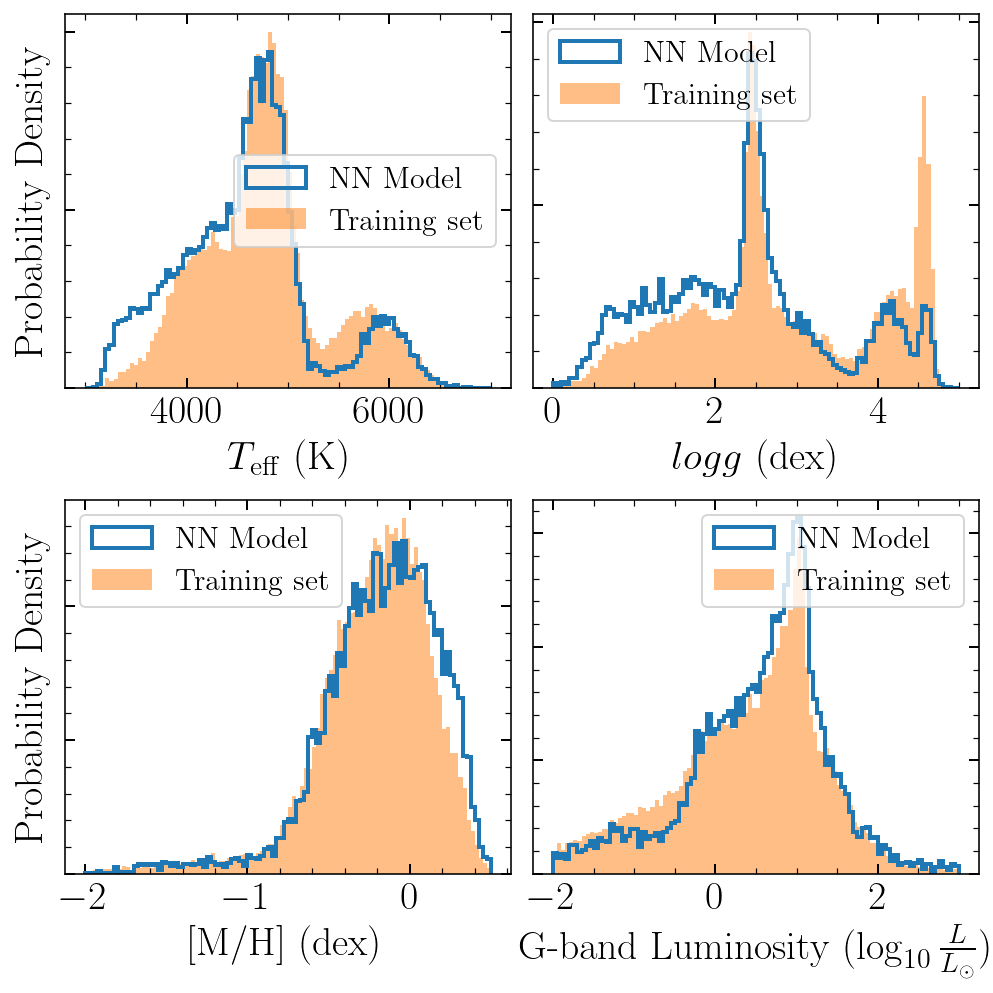

In [28]:
nn_teff_pred = nn_model.predict_samples(request_tokens="teff", size=10000)
training_teff = val_labels_df["teff"].to_numpy()
nn_logg_pred = nn_model.predict_samples(request_tokens="logg", size=10000)
training_logg = val_labels_df["logg"].to_numpy()
nn_mh_pred = nn_model.predict_samples(request_tokens="m_h", size=10000)
training_mh = val_labels_df["m_h"].to_numpy()
nn_gfakemag_pred = nn_model.predict_samples(request_tokens="g_fakemag", size=10000)
training_gfakemag = val_labels_df["g_fakemag"].to_numpy()


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7))

ax1.hist(
    nn_teff_pred,
    range=(3000.0, 7000.0),
    bins=100,
    density=True,
    lw=2.0,
    histtype="step",
    label="NN Model",
)
ax1.hist(
    training_teff,
    range=(3000.0, 7000.0),
    bins=100,
    density=True,
    alpha=0.5,
    label="Training set",
    rasterized=True,
)
ax1.set_xlabel(r"$T_{\mathrm{eff}}$ (K)")
ax1.set_ylabel("Probability Density")
ax1.set_yticklabels([])
ax1.legend(loc="best")

ax2.hist(
    nn_logg_pred,
    range=(0, 5),
    bins=100,
    density=True,
    lw=2.0,
    histtype="step",
    label="NN Model",
)
ax2.hist(
    training_logg,
    range=(0, 5),
    bins=100,
    density=True,
    alpha=0.5,
    label="Training set",
    rasterized=True,
)
ax2.set_xlabel(r"$\\log g$ (dex)")
# ax2.set_ylabel("Density")
ax2.set_yticklabels([])
ax2.legend(loc="best")

ax3.hist(
    nn_mh_pred,
    range=(-2.0, 0.5),
    bins=100,
    density=True,
    lw=2.0,
    histtype="step",
    label="NN Model",
)
ax3.hist(
    training_mh,
    range=(-2.0, 0.5),
    bins=100,
    density=True,
    alpha=0.5,
    label="Training set",
    rasterized=True,
)
ax3.set_xlabel("[M/H] (dex)")
ax3.set_ylabel("Probability Density")
ax3.set_yticklabels([])
ax3.legend(loc="best")

ax4.hist(
    fakemag_to_logsol(nn_gfakemag_pred),
    range=(-2, 3),
    bins=100,
    density=True,
    lw=2.0,
    histtype="step",
    label="NN Model",
)
ax4.hist(
    fakemag_to_logsol(training_gfakemag),
    range=(-2, 3),
    bins=100,
    density=True,
    alpha=0.5,
    label="Training set",
    rasterized=True,
)
ax4.set_xlabel("G-band Luminosity ($\\log_{10}{\\frac{L}{L_\\odot}}$)")
ax4.set_yticklabels([])
ax4.legend(loc="best")

# ax4.hist(teff_quantiles, density=True, bins=10, alpha=0.5, label=r"$T_{\mathrm{eff}}$")
# ax4.hist(logg_quantiles, density=True, bins=10, alpha=0.5, label=r"$\\log g$")
# ax4.hist(mh_quantiles, density=True, bins=10, alpha=0.5, label="[M/H]")
# ax4.axhline(1.0, color="r", linestyle="--", lw=2.0, label="Matched Perfectly")
# ax4.set_xlabel("Quantile")
# ax4.set_ylabel("Density")
# ax4.set_xlim(0., 1.)
# ax4.set_ylim(0., 2.)
# ax4.legend(loc="best")

fig.tight_layout()
fig.savefig("figs/no_conditions.pdf")

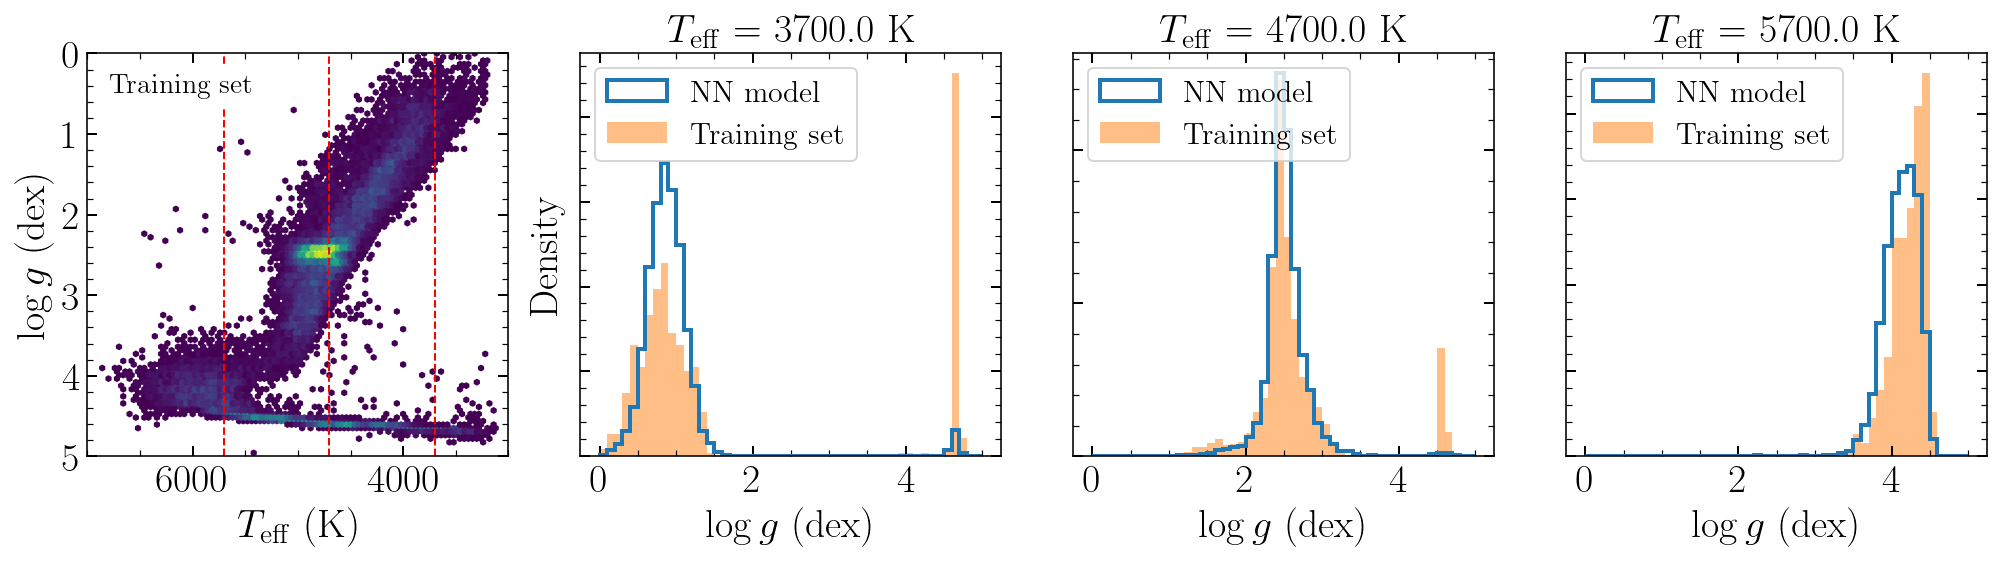

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4))

for ax, t in zip(axes[1:], [3700.0, 4700.0, 5700.0]):
    axes[0].axvline(t, c="r", ls="--")
    ax.set_title(f"$T_{{\\rm eff}}$ = {t} K")
    x = nn_model.predict_samples(
        inputs=[t], input_tokens=["teff"], request_tokens="logg", size=10000
    )
    _ = ax.hist(
        x[:, 0],
        range=(0, 5),
        bins=50,
        density=True,
        lw=2.0,
        histtype="step",
        label="NN model",
    )
    # ground truth
    training_logg = val_labels_df[
        (val_labels_df["teff"] > t - 50.0) & (val_labels_df["teff"] < t + 50.0)
    ]["logg"].to_numpy()
    _ = ax.hist(
        training_logg,
        range=(0, 5),
        bins=50,
        density=True,
        alpha=0.5,
        # histtype="step",
        label="Training set",
        rasterized=True,
    )
    # quantile test
    # quantiles = [(training_logg<i).mean() for i in x]
    # axes[4].hist(quantiles, density=True, bins=10, alpha=0.5, label=f"{t} K")

    ax.set_xlabel(r"$\log g$ (dex)")
    ax.legend(loc="upper left")
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])
axes[3].set_yticklabels([])
axes[1].set_ylabel("Density")

axes[0].hexbin(
    xp_apogee_testing["raw"]["teff"],
    xp_apogee_testing["raw"]["logg"],
    extent=(3000, 7000, 0, 5),
    mincnt=1,
)
axes[0].set_xlim(7000, 3000)
axes[0].set_ylim(5, 0)
axes[0].set_xlabel("$T_{\\rm eff}$ (K)")
axes[0].set_ylabel("$\\log g$ (dex)")
axes[0].text(
    0.05,
    0.95,
    "Training set",
    transform=axes[0].transAxes,
    fontsize=14,
    ha="left",
    va="top",
    backgroundcolor="white",
)

fig.tight_layout()
fig.savefig("figs/teff_logg_distribution.pdf")

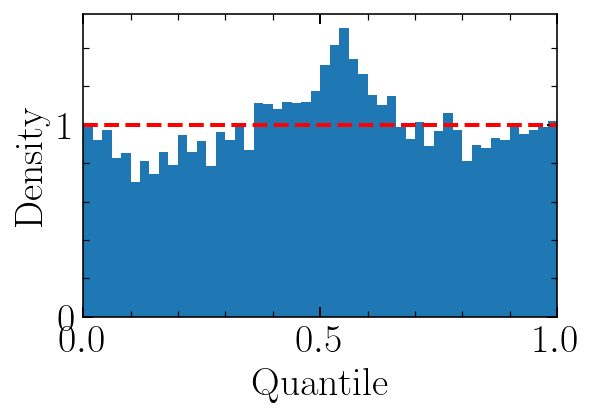

In [20]:
from stellarperceptron.nn_utils import TrainingGenerator

val_labels_standardized = nn_model.standardize(
    val_labels, nn_model.tokenize(obs_names, data_length=len(val_labels))
)[0]

val_generator = TrainingGenerator(
    batch_size=1024,
    data={
        "input": val_labels,
        "input_token": nn_model.tokenize(obs_names, data_length=len(val_labels)),
        "output": val_labels,
        "output_err": np.zeros_like(val_labels),
    },
    shuffle=False,
    aggregate_nans=False,
    length_range=(0, 64),
    possible_output_tokens=np.arange(1, 119),
    factory_kwargs=nn_model.factory_kwargs,
)
quantiles = []
all_label_token = []
for inputs, input_token, label_token, label, label_err in val_generator:
    with torch.inference_mode():
        result = nn_model.predict_samples(
            inputs=inputs.cpu().numpy()[:, :, 0],
            input_tokens=input_token.cpu().numpy(),
            request_tokens=label_token.cpu().numpy(),
            size=1000,
        )
    # quantile test
    quantiles.append([(label.cpu().numpy() < i).mean() for i in np.mean(result, axis=0)])
    all_label_token.append(label_token.cpu().numpy())
    
fig, ax1 = plt.subplots(1, 1, figsize=(4.5, 3))
ax1.hist(np.stack(quantiles).flatten(), range=(0, 1), bins=50, density=True, rasterized=True)
ax1.axhline(1.0, color="r", linestyle="--", lw=2.0, label="Matched Perfectly")
ax1.set_xlim(0, 1)
ax1.set_xlabel("Quantile")
ax1.set_ylabel("Density")
fig.tight_layout()
plt.savefig("figs/quantile_test.pdf")

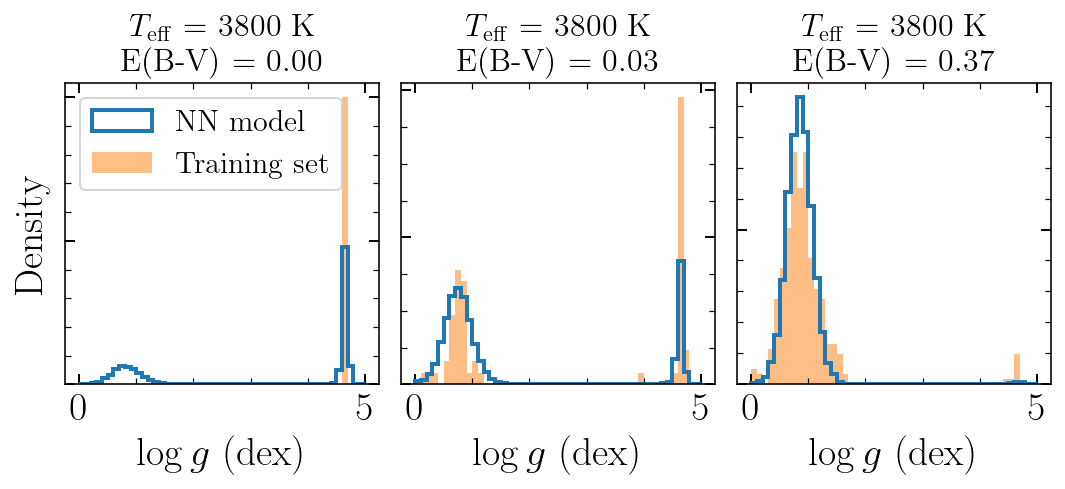

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(7.5, 3.5))
first = True

for ax, t in zip(axes, np.linspace(-6, -1, 3)):
    ax.set_title(f"$T_{{\\rm eff}}$ = 3800 K\nE(B-V) = {np.exp(t):.2f}", fontsize=16)
    x = nn_model.predict_samples(
        inputs=[3800, t],
        input_tokens=["teff", "logebv"],
        request_tokens="logg",
        size=10000,
    )
    _ = ax.hist(
        x[:, 0],
        range=(0, 5),
        bins=50,
        density=True,
        histtype="step",
        lw=2.0,
        label="NN model",
    )
    training_logg = val_labels_df[
        (val_labels_df["teff"] > 3800 - 50.0)
        & (val_labels_df["teff"] < 3800 + 50.0)
        & (val_labels_df["logebv"] > t - 1.0)
        & (val_labels_df["logebv"] < t + 1.0)
    ]["logg"].to_numpy()
    _ = ax.hist(
        training_logg,
        range=(0, 5),
        bins=50,
        density=True,
        alpha=0.5,
        # histtype="step",
        label="Training set",
        rasterized=True,
    )
    ax.set_xlabel(r"$\log g$ (dex)")
    if first:
        ax.legend(loc="best")
        first = False
    ax.set_yticklabels([])
axes[0].set_ylabel("Density")
fig.tight_layout()
fig.savefig("figs/teff_extinction.pdf")

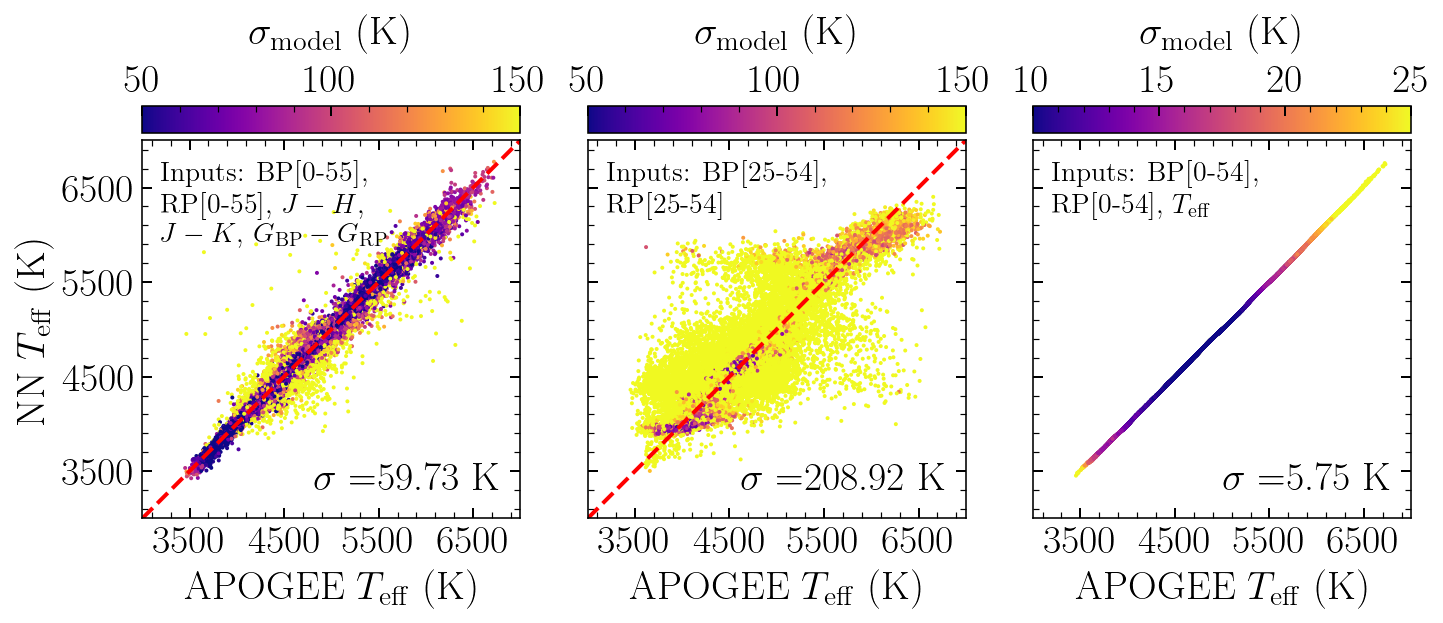

In [9]:
# this notebook is about inference from XP spectra, so we at least need XP spectra and APOGEE labels
good_idx = (
    (np.sum(np.isnan(xp_apogee_testing["raw"]["xp_coeffs_gnorm"][()]), axis=1) == 0)
    & ~np.isnan(xp_apogee_testing["raw"]["teff"][()])
    & ~np.isnan(xp_apogee_testing["raw"]["logg"][()])
    & ~np.isnan(xp_apogee_testing["raw"]["m_h"][()])
)

val_labels = np.column_stack(
    [
        xp_apogee_testing["raw"]["xp_coeffs_gnorm"][()],
        xp_apogee_testing["raw"]["bprp"][()],
        xp_apogee_testing["raw"]["jh"][()],
        xp_apogee_testing["raw"]["jk"][()],
        xp_apogee_testing["raw"]["teff"][()],
        xp_apogee_testing["raw"]["logg"][()],
        xp_apogee_testing["raw"]["m_h"][()],
        xp_apogee_testing["raw"]["logc19"][()],
        xp_apogee_testing["raw"]["g_fakemag"][()],
    ]
)[good_idx]

obs_names = np.stack(
    [
        *[f"bp{i}" for i in range(55)],
        *[f"rp{i}" for i in range(55)],
        "bprp",
        "jh",
        "jk",
        "teff",
        "logg",
        "m_h",
        "logebv",
        "g_fakemag",
    ]
)


def plot_teff(
    ax, x, y, y_err=None, cmap="plasma", text=None, plot121=True, vmin=50, vmax=150
):
    if y_err is None:
        custom_cmap = copy.copy(plt.get_cmap(cmap))
        custom_cmap.set_under(color="white")
        mappable = ax.hexbin(
            x,
            y,
            bins="log",
            extent=[3000, 7000, 3000, 7000],
            cmap=custom_cmap,
            vmin=1.1,
            rasterized=True,
        )
        top_cbar(ax, mappable, "log$_{10}$ N", labelpad=10)
    else:
        mappable = ax.scatter(
            x,
            y,
            c=y_err,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            s=1,
            rasterized=True,
        )
        top_cbar(ax, mappable, "$\\sigma_\\mathrm{model}$ (K)", labelpad=10)
    if plot121:
        ax.plot([3000, 7000], [3000, 7000], lw=2, ls="--", c="r")

    if text:
        ax.annotate(
            text, xy=(0.05, 0.95), xycoords=ax, fontsize=14, ha="left", va="top"
        )
    ax.annotate(
        f"$\\sigma=${mad_std(x-y, ignore_nan=True):.2f} K",
        xy=(0.95, 0.15),
        xycoords=ax,
        fontsize=20,
        ha="right",
        va="top",
    )
    ax.plot([-1, 3], [-1, 3], lw=2, ls="--", c="r")
    ax.set_xlim(3000, 7000)
    ax.set_ylim(3000, 7000)
    ax.set_xticks([3500, 4500, 5500, 6500])
    ax.set_yticks([3500, 4500, 5500, 6500])
    ax.set_aspect("equal", "box")
    ax.set_xlabel("APOGEE $T_\\mathrm{eff}$ (K)")
    ax.set_ylabel("NN $T_\\mathrm{eff}$ (K)")
    return mappable


fig, ax = plt.subplots(1, 3, figsize=(10, 4.5))

# Best Case
# create pandas DataFrame for validation set
val_labels_pd = pd.DataFrame(data=val_labels, columns=obs_names)
col_names = [
    *[f"bp{i}" for i in range(55)],
    *[f"rp{i}" for i in range(55)],
    *["jh", "jk", "bprp"],
]
val_labels_shuffled = val_labels_pd[col_names]
test_data_length = len(val_labels_pd)
val_labels_names = np.tile(col_names, (test_data_length, 1))
x = nn_model.predict_summary(
    inputs=val_labels_shuffled,
    input_tokens=val_labels_names,
    request_tokens=["teff"],
    batch_size=128,
    size=1000,
)
plot_teff(
    ax[0],
    val_labels_pd["teff"],
    x["teff"],
    y_err=x["teff_error"],
    text="Inputs: BP[0-55],\nRP[0-55], $J-H$, \n$J-K$, $G_\\mathrm{BP}-G_\\mathrm{RP}$",
)

# Worst Case
col_names = [
    *[f"bp{i}" for i in range(25, 55)],
    *[f"rp{i}" for i in range(25, 55)],
]

val_labels_shuffled = val_labels_pd[col_names]
test_data_length = len(val_labels_pd)
val_labels_names = np.tile(col_names, (test_data_length, 1))
x = nn_model.predict_summary(
    inputs=val_labels_shuffled,
    input_tokens=val_labels_names,
    request_tokens=["teff"],
    size=1000,
)
plot_teff(
    ax[1],
    val_labels_pd["teff"],
    x["teff"],
    y_err=x["teff_error"],
    text="Inputs: BP[25-54],\nRP[25-54]",
)
ax[1].set_ylabel(None)
ax[1].set_yticklabels([])


# Best Case
col_names = [
    *[f"bp{i}" for i in range(25, 55)],
    *[f"rp{i}" for i in range(25, 55)],
    *["jh", "jk", "teff"],
]
val_labels_shuffled = val_labels_pd[col_names]
test_data_length = len(val_labels_pd)
val_labels_names = np.tile(col_names, (test_data_length, 1))
x = nn_model.predict_summary(
    inputs=val_labels_shuffled, input_tokens=val_labels_names, request_tokens=["teff"], size=1000
)
plot_teff(
    ax[2],
    val_labels_pd["teff"],
    x["teff"],
    y_err=x["teff_error"],
    plot121=False,
    text="Inputs: BP[0-54], \nRP[0-54], $T_\\mathrm{eff}$",
    vmin=10,
    vmax=25,
)
ax[2].set_ylabel(None)
ax[2].set_yticklabels([])
fig.tight_layout()
fig.savefig("figs/teff_accurancy.pdf")

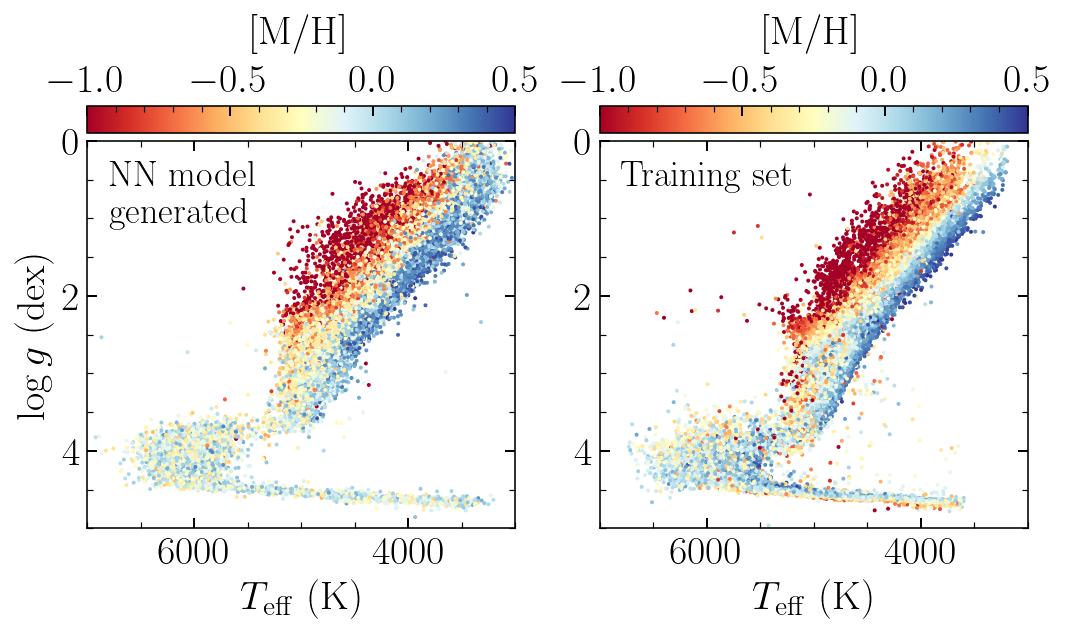

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 4.5))
num_m_h = 500
conditional_m_h = nn_model.predict_samples(
    inputs=[-9999.99], input_tokens=[0], request_tokens=["m_h"], size=num_m_h
)[:, 0]
for i in range(num_m_h):
    logg = nn_model.predict_samples(
        inputs=[conditional_m_h[i]],
        input_tokens=["m_h"],
        request_tokens=["logg"],
        size=80,
    )[:, 0]
    teff = nn_model.predict_samples(
        inputs=np.column_stack([[conditional_m_h[i]] * len(logg), logg]),
        input_tokens=["m_h", "logg"],
        request_tokens=["teff"],
        size=1,
        batch_size=8,
    )[0]
    mappable = ax1.scatter(
        teff,
        logg,
        c=len(teff) * [conditional_m_h[i]],
        s=1,
        vmin=-1.0,
        vmax=0.5,
        cmap="RdYlBu",
        rasterized=True,
    )
ax1.set_xlim(7000, 3000)
ax1.set_ylim(5, 0)
ax1.set_xlabel("$T_{\\rm eff}$ (K)")
ax1.set_ylabel("$\\log g$ (dex)")
ax1.text(
    0.05,
    0.95,
    "NN model\ngenerated",
    transform=ax1.transAxes,
    fontsize=18,
    ha="left",
    va="top",
    backgroundcolor="white",
)
top_cbar(ax1, mappable, "[M/H]", labelpad=10)

ax2.scatter(
    xp_apogee_testing["raw"]["teff"],
    xp_apogee_testing["raw"]["logg"],
    c=xp_apogee_testing["raw"]["m_h"],
    s=1,
    vmin=-1.0,
    vmax=0.5,
    cmap="RdYlBu",
    rasterized=True,
)
ax2.set_xlim(7000, 3000)
ax2.set_ylim(5, 0)
ax2.set_xlabel("$T_{\\rm eff}$ (K)")
ax2.text(
    0.05,
    0.95,
    "Training set",
    transform=ax2.transAxes,
    fontsize=18,
    ha="left",
    va="top",
    backgroundcolor="white",
)
top_cbar(ax2, mappable, "[M/H]", labelpad=10)
fig.tight_layout()
fig.savefig("figs/kiel_generated.pdf")